## Computing Edges of lexical/semantic graph

Galea, et al., 2015 use cosine similarity to compute the edges of the graph:

\begin{equation}
E_{ij} = \cos(w_i, w_j) = \frac{\langle w_i, w_j \rangle}{||w_i||~||w_j||}
\end{equation}

Hamilton, et al., 2016 on the other hand define, in their Equation 3, edge weight by inverse cosine of the negative cosine similarity,

\begin{equation}
E_{ij} = \arccos(- ~ \frac{\langle w_i, w_j \rangle}{||w_i||~||w_j||})
\end{equation}

What does this do? Let's consider a couple of vectors and see the differences...

In [5]:
from numpy.linalg import norm
from numpy import arccos

def cos_sim(x, y):
    return x.dot(y) / (norm(x)*norm(y))

def ham(x, y):
    return arccos(- cos_sim(x, y))

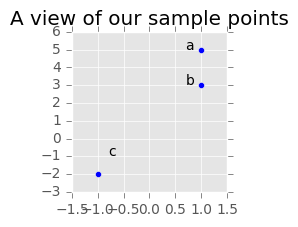

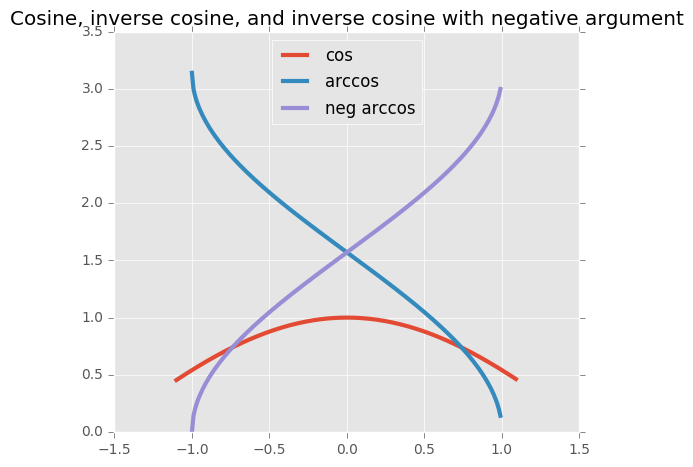

Cosine Similarity:
ab: 0.9922778767136677	bc: -0.9899494936611664	 ac:-0.9647638212377322
Hamilton 2016 Similarity:
ab: 3.0172376590430323	bc: 0.14189705460416518	 ac:0.26625204915092515


In [30]:
from numpy import array, arange, pi, cos, arccos
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# some fake points in 2D "semantic space"
a = array([1.0, 5.0])
b = array([1.0, 3.0])
c = array([-1.0, -2.0])

# plot our points
plt.figure(figsize=(2, 2))
plt.scatter(*zip(a, b, c))
plt.text(.7, 5, 'a')
plt.text(.7, 3, 'b')
plt.text(-.8, -1, 'c')
plt.title('A view of our sample points')
plt.show()

# plot cos and arccos just for a reminder of the shapes
x = arange(-1.1, 1.1, .01)
cos_ = cos(x)
arccos_ = arccos(x)
negarccos = arccos(-x)

plt.figure(figsize=(6, 5))
plt.plot(x, cos_, lw=3, label='cos')
plt.plot(x, arccos_, lw=3, label='arccos')
plt.plot(x, negarccos, lw=3, label='neg arccos')
plt.title('Cosine, inverse cosine, and inverse cosine with negative argument')
plt.legend(loc='upper center')
plt.show()

# compute the cosine and arccos similarities
ab = cos_sim(a, b)
bc = cos_sim(b, c)
ac = cos_sim(a, c)

hab = ham(a, b)
hbc = ham(b, c)
hac = ham(a, c)


print("Cosine Similarity:\nab: {}\tbc: {}\t ac:{}".format(ab, bc, ac))
print("Hamilton 2016 Similarity:\nab: {}\tbc: {}\t ac:{}".format(hab, hbc, hac))

### cos/arccos conclusion

So the Hamilton, et al., measure just takes the output from the cosine similarity, which is in $[-1, 1]$ generally and in $[0, 1]$ for PPMI vectors, and maps it to $[0, \infty)$

## Building the $U$ vector representation of each word

Now we'll build the vector representation of each word. There are many ways to do this. In latent semantic analysis, one simply takes word counts over vectors to create a word-document matrix. We will follow a common scheme and build our initial vector space model (VSM) of our corpus by building a positive pointwise mutual information to construct our word vectors. PPMI-based word vectors form a vector space over contexts instead of documents as in LSA (Levy, et al., 2015).

### Step 1) Build PPMI matrix

Following Levy, et al., (2015) we will use a smoothed PPMI implementation. First we write the equation for PPMI, which is

\begin{equation}
M^{PMI}(w_i, w_j) = \log \frac{P(w_i, w_j)}{P(w_i)P(w_j)}
\end{equation}

$P_q(w_i, w_j)$ is the joint probability that $w_i$ occurs in a window of $q$ words ahead of $w_j$. $q$ is a parameter that we are free to vary. Following Hamilton, et al., (2016) we'll set a window size of $f=4$. $P(w_i) = f(w_i)/N$ where $N$ is the total number of words in the corpus and $P_q(w_i, w_j) = f_q(w_i, w_j)$, where $f_q$ counts the number of times $w_i$ occurs within the first $q$ words following $w_j$.

The matrix $M$ is so named to represent _mutual_ information between two words. All $N$ words could possibly be either a beginning word or a context word, so $M^{PMI} \in \mathbb{R}^{N \times N}$. Entries will be floored at zero so the final equation for our positive pointwise mutual information matrix is

\begin{equation}
M^{PPMI}_{ij} = \mathrm{max} \left \{ M^{PMI}_{ij}, 0 \right \}
\end{equation}


### Step 2) Build low-dimensional embedding via SVD

The singular value decomposition (SVD) can be used for building low-dimensional representations of the $w_i$ contained in the $M^{PPMI}$ matrix. The SVD is written $M^{PPMI} = U\Sigma V^{\intercal}$. Then the representations we will use to compare word vector similarity is the representation of each word in terms of a smaller number of context words. 
The SVD gives us as close to an orthonormal basis for the representation of words in context space. The rows of
$U$ are the contextual embeddings for each word, 

\begin{equation}
w_i^{SVD} = (U)_i
\end{equation}


### Step 3) Define graph edges

Finally we will calculate the weight of the graph edges between $w_i$ and $w_j$, given as

\begin{equation}
\mathbf{E}_{ij} = \arccos \left (- \frac{w_i^{\intercal}w_j}{||w_i||~||w_j||} \right )
\end{equation}

Below we write out the code for implementing these functions. There is a trade secret, which is keeping track of the words associated with each row of the matrices. I'll keep those in a separate dictionary, adding a new one as it comes along. We'll work on texts that have already been generated, namely the ones saved to `fox_texts.txt` and `msnbc_texts.txt`. 

Counts:

[('leaks', 10, 1), ('wait', 5, 1), ('McDonalds', 13, 1), ('go', 6, 1), ('Burger', 19, 1), ('mall', 2, 1), ('favorite', 15, 1), ('slows', 12, 1), ('always', 11, 1), ('drag', 21, 1), ('disgusting', 22, 1), ('tasty', 18, 1), ('I', 0, 3), ('really', 3, 1), ('hate', 7, 2), ('bike', 8, 1), ('King', 20, 1), ('eat', 17, 1), ('fun', 4, 2), ('went', 1, 1), ('one', 14, 1), ('tire', 9, 1), ('places', 16, 1)]

Context Counts:

{('mall', 'fun'): 1, ('eat', 'fun'): 1, ('Burger', 'drag'): 1, ('wait', 'go'): 1, ('one', 'places'): 1, ('McDonalds', 'favorite'): 1, ('King', 'disgusting'): 1, ('really', 'fun'): 1, ('King', 'drag'): 1, ('I', 'hate'): 2, ('I', 'went'): 1, ('fun', 'go'): 1, ('tire', 'always'): 1, ('drag', 'disgusting'): 1, ('I', 'bike'): 1, ('hate', 'Burger'): 1, ('I', 'mall'): 1, ('hate', 'tire'): 1, ('really', 'wait'): 1, ('leaks', 'always'): 1, ('favorite', 'places'): 1, ('places', 'eat'): 1, ('hate', 'bike'): 1, ('bike', 'tire'): 1, ('McDonalds', 'one'): 1, ('eat', 'tasty'): 1, (

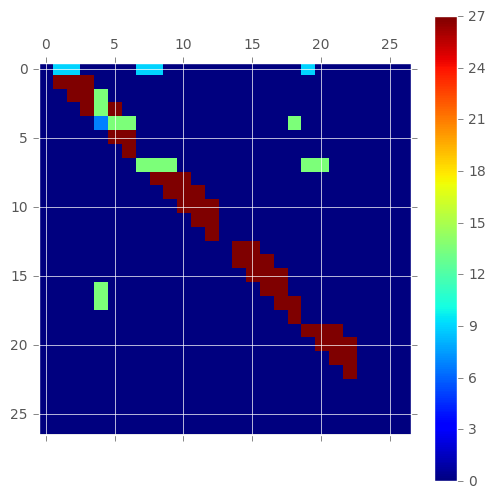

In [89]:
from nltk.corpus import stopwords

STOPWORDS = stopwords.words('english')


class LookupCount:
    def __init__(self, index):
        self.index = index
        self.count = 1


# we first need to iterate through the texts to find $f_q(x, y)$ for all $x$ and $y$
def _calculate_ppmi(texts, window_distance, alpha, saveroot='ppmi_calculation'):
    '''
    
    '''
    word_lookup_counts = {}
    context_lookup_counts = {}
    word_idx = 0
    
    # step 1) individual word counts and joint word/context counts
    for text in texts:
        for ii, word in enumerate(text):
    
            # handle single-word frequency
            if word not in word_lookup_counts:
                word_lookup_counts.update({word: LookupCount(word_idx)})
                word_idx += 1
            else:
                word_lookup_counts[word].count += 1
            
            # determine f_q(x, y)
            # first, window indices
            w1 = ii + 1
            w2 = ii + 1 + window_distance
            for context in text[w1:w2]:
                if (word, context) not in context_lookup_counts:
                    context_lookup_counts.update({(word, context): 1})
                else:
                    context_lookup_counts[(word, context)] += 1
    
    
    
    
    # step 2) process word and joint counts to calculate PPMI matrix
    
    N = np.sum([w.count for w in word_lookup_counts.values()])
    ppmi_matrix = np.zeros((N, N))
    
    word_context_pairs = set(context_lookup_counts.keys())
    
    for word, lookup_count in word_lookup_counts.items():
        
        i = lookup_count.index
        P_word = lookup_count.count/N
        
        relevant_pairs = [wc_pair for wc_pair in word_context_pairs if word in wc_pair]
        
        for pair in relevant_pairs:
            context = pair[1]
            context_wlc = word_lookup_counts[context]
            
            j = context_wlc.index
            P_context = context_wlc.count / N
            P_joint = context_lookup_counts[pair] / N
            
            pmi_val = P_joint / (P_context * P_word)
            
            ppmi_matrix[i, j] = pmi_val if pmi_val > 0 else 0
    
#    with open(saveroot + '.word') as f:
      #  f.write('yo')
    #with open(saveroot + '.contextword') as f:
     #   f.write('context word, yo')
    np.savetxt(saveroot + '.ppmi_matrix', ppmi_matrix)
    
    return word_lookup_counts, context_lookup_counts, ppmi_matrix


# some of these have been "cleaned" already, but I'll get rid of stopwords in a sec...
texts = [
    "I went to the mall and it was really fun can't wait to go again".split(),
    "I hate when my bike tire leaks it always slows me down".split(),
    "McDonalds is one of my favorite places to eat it's fun and tasty".split(),
    "I hate Burger King what a drag disgusting".split()
]

texts = [[w for w in t if w.isalpha() and w not in STOPWORDS] for t in texts]

wc, wcc, ppmi = _calculate_ppmi(texts, 2, 1.0)

print('Counts:\n')
print([(k, v.index, v.count) for k, v in wc.items()])

print('\nContext Counts:\n')
print(wcc)

print('\nppmi:')
# print(np.where(ppmi > 20))

plt.matshow(ppmi)
plt.colorbar()
plt.show()

It makes sense in this small example that the highest PPMI would be near the diagonal since there are very few words and the "corpus" is very small. What is the meaning of no/low PPMI on/near the diagonal?

## Calculating the edge weights between words

Now we'll implement steps 2) and 3) from the above section

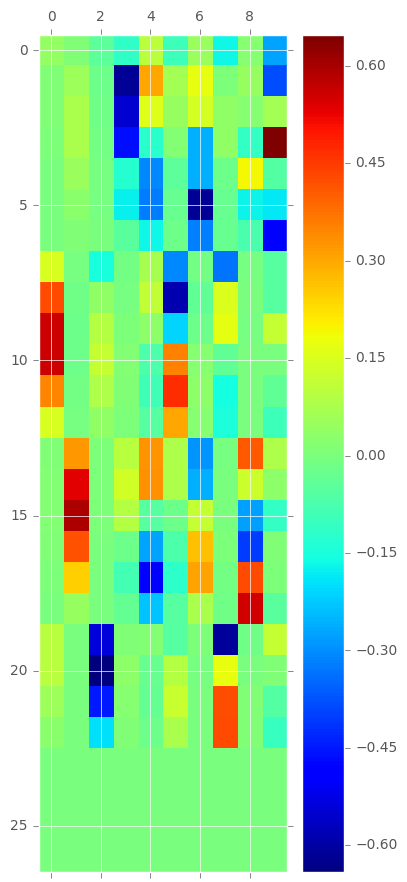

In [104]:
U, s, V = np.linalg.svd(ppmi)

plt.figure(figsize=(3, 3))
plt.matshow(U[:,:10], aspect='auto')
plt.colorbar()
plt.show()

In [120]:
from numpy.linalg import norm
from numpy import arccos

def cos_sim(x, y):
    if norm(x)*norm(y) > 0:
        return x.dot(y) / (norm(x)*norm(y))
    else:
        return 0

def ham(x, y):
    return arccos(- cos_sim(x, y))

def calculate_edgeweights(U_reduced):
    nrows = U_reduced.shape[0]
    combos = [(i, j) for i in range(nrows) for j in range(nrows) if i != j]
    weights = {
        (i, j): ham(U_reduced[i], U_reduced[j])
        for i, j in combos
    }
    
    return weights
    
edges = calculate_edgeweights(U[:,:10])

threes = [(3, i) for i in range(27) if i !=3]

word_three = [(pair, edges[pair]) for pair in threes]
word_three.sort(key=lambda x: -x[1])
print(word_three)

[((3, 2), 2.0683395148669352), ((3, 5), 1.8449250560969166), ((3, 4), 1.8418539325965733), ((3, 9), 1.7135231975556058), ((3, 16), 1.6630091114298409), ((3, 19), 1.6424488534867401), ((3, 13), 1.606285540985612), ((3, 20), 1.5928177943629289), ((3, 14), 1.5893910141133434), ((3, 10), 1.5748387951969185), ((3, 23), 1.5707963267948966), ((3, 24), 1.5707963267948966), ((3, 25), 1.5707963267948966), ((3, 26), 1.5707963267948966), ((3, 17), 1.5696709348636158), ((3, 21), 1.5308663164526073), ((3, 11), 1.5192227103435569), ((3, 8), 1.5098530933491137), ((3, 1), 1.5019395925046299), ((3, 15), 1.4666424418446928), ((3, 7), 1.4474019516448362), ((3, 22), 1.4456222139951627), ((3, 18), 1.4443388438471323), ((3, 12), 1.3802432046850404), ((3, 6), 1.2165655814437688), ((3, 0), 1.0590507868264472)]


In [137]:
wcl = list(wc.items())

twos = [(2, i) for i in range(27) if i !=2]
word_two = [(pair, edges[pair]) for pair in twos]
word_two.sort(key=lambda x: -x[1])

print('word three:')
print(list(filter(lambda x: x[1] == 3, [(k, v.index) for k, v in wcl])))

print('\nfive closes matches for word three:')
print(list(filter(lambda x: x[1] in [el[0][1] for el in word_three[:5]], [(k, v.index) for k, v in wcl])))

print('\nword two:')
print(list(filter(lambda x: x[1] == 2, [(k, v.index) for k, v in wcl])))

print('\nfive closes matches for word two:')
print(list(filter(lambda x: x[1] in [el[0][1] for el in word_two[:5]], [(k, v.index) for k, v in wcl])))

word three:
[('really', 3)]

five closes matches for word three:
[('wait', 5), ('mall', 2), ('fun', 4), ('tire', 9), ('places', 16)]

word two:
[('mall', 2)]

five closes matches for word two:
[('I', 0), ('really', 3), ('eat', 17), ('went', 1), ('places', 16)]


So next, need to wrap this all up so you can get results intuitively. For example call

```python
nn = get_knn('climate', k=5)
```

to get the 5 nearest neighbor terms to climate.

## References

Church, K. W., & Hanks, P. (1990). Word association norms, mutual information, and lexicography. Computational Linguistics, 16(1), 22–29.

Galea, D., & Bruza, P. (2015). Deriving Word Association Networks from Text Corpora. In G. Aitenti, B. G. Bara, & G. Sandini (Eds.), Proceedings of the EuroAsianPacific Joint Conference on Cognitive Science (EAPCogSci 2015) (pp. 252–257).

Hamilton, W. L., Clark, K., Leskovec, J., & Jurafsky, D. (2016). Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora. arxiv. Retrieved from http://arxiv.org/abs/1606.02820

Levy, O., Goldberg, Y., & Dagan, I. (2015). Improving Distributional Similarity with Lessons Learned from Word Embeddings. Transactions of the Association for Computational Linguistics, 3, 211–225. http://doi.org/10.1186/1472-6947-15-S2-S2

## Linear algebra reference

I seem to forget this stuff easily, so just to remember: 

**Matrix notation:** $M_{ij}$ refers to the $i^{th}$ row and the $j^{th}$ column. So $M_{ij}$ is the information between the $i^{th}$ word and the $j^{th}$ context word. 

There seems to be a difference between Church & Hanks (1990) and Hamilton, et al., (2016). I'm following the more intuitive one, Hamilton. This is because in both $M$ and the $U$ vector of the Likely they are the same and I'm not seeing how.

In [95]:
from numpy.random import randn
from numpy.linalg import svd
import numpy as np

M = randn(5, 5)

U, s, V = svd(M)

print(M, M.shape)
print(U, U.shape)
print(s, s.shape)
print(V, V.shape)

S = np.diag(s)
np.allclose(M, np.dot(U, np.dot(S, V)))

print(U[:,0])

print("\nNow let's make sure our scheme for dimensionality reduction works as I am expecting\n")
print(U[:,:3])
print("\nThe reduced representation of M\n")
W = np.dot(U, S[:,:3])
print(W)

[[-0.47450245  1.7048964   0.81041661 -0.87404364  0.51674321]
 [-1.1133748  -0.20561769 -1.33632836  0.54599957 -0.50294158]
 [ 1.88817275 -1.07047178  1.22899156  0.27393265 -0.53888808]
 [-0.62083756 -0.5856694  -0.26654117 -1.16803877 -1.09570118]
 [-1.12396681 -0.15663026 -2.9392906   0.94103238 -0.0941142 ]] (5, 5)
[[ 0.15498944  0.75883436  0.00829783  0.24606208 -0.58269485]
 [-0.43141024 -0.07745835 -0.13397258 -0.71973267 -0.52146107]
 [ 0.44846554 -0.62417521  0.03097312  0.22572138 -0.59780808]
 [-0.08617271 -0.03764774 -0.96897141  0.2283361   0.01067495]
 [-0.76244109 -0.1647986   0.20522567  0.56422587 -0.17622885]] (5, 5)
[ 4.22532159  2.73931552  1.84794415  0.53412097  0.39232433] (5,)
[[ 0.51215428  0.01012157  0.83242814 -0.20471736  0.05243795]
 [-0.45404697  0.73948557  0.16274188 -0.36054092  0.30087832]
 [ 0.31094768  0.29432198 -0.065546    0.67805246  0.59383053]
 [ 0.62690917  0.19427703 -0.52546733 -0.52789702  0.12020877]
 [-0.20453794 -0.57331462  0.012894